## Step 1
- Given $v_c/v_A$ and $\beta_p$, make contour in $k$ space

<table>
<tr>
    <td><img src="figure/gary_1975_fig4.png" width=400></td>
    <td><img src="figure/gary_1975_fig4_reproduced.png" width=400></td>
</tr>
</table>

In [2]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

In [6]:
def generate_k_arr(start_k, target_k, log_incrmt = None, lin_incrmt = None):
    assert log_incrmt or lin_incrmt
    if log_incrmt:
        n = int(np.log(target_k/start_k) / np.log(1 + log_incrmt))
        ret = np.arange(n + 1) * np.log(1 + log_incrmt)
        return np.exp(ret)  * start_k
    else:
        n = (target_k - start_k) / lin_incrmt
        if n - int(n) > 1 - 1e-5:
            n = int(n) + 1
        return start_k + np.arange(n + 1) * lin_incrmt

In [389]:
generate_k_arr(0.2, 1, lin_incrmt=0.05).shape

(17,)

## parameters

In [33]:
aol = np.sqrt(2.65e-8)
print('aol = ', aol)
tc_tp = 2
th_tc = 6
nc_np = 0.95
nh_np = 1 - nc_np
vc_va = 2.42
vh_va = -vc_va * nc_np / nh_np
print('vh_va = {0:.3g}'.format(vh_va))

betap = 0.25
theta = 80


t_list=[1., tc_tp, th_tc * tc_tp]
a_list=[1., 1., 1.]
n_list=[1., nc_np, nh_np] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., vc_va, vh_va]
n = 6
method = 'pade'

k = 0.2

target_k = 2

aol =  0.000162788205961
vh_va = -46


In [34]:
kz, kp = kzkp(k, theta)
seed_freq = kz / np.sqrt(betap)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

guess = seed_freq

freq = follow_k(guess, target_k, param,
                lin_incrmt = 0.05, incrmt_method = 'linear')    

In [35]:
k_arr = generate_k_arr(k, target_k, lin_incrmt=0.05)
wrel = np.array(freq[-1])

(-0.01, 0.01)

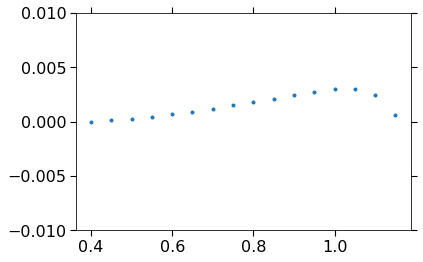

In [40]:
mask = wrel.imag > 1e-6
plt.plot(k_arr[mask], wrel.imag[mask], '.')
plt.ylim([-1e-2,  .01])

## try different angles

In [355]:
def try_theta(theta):
    kz, kp = kzkp(k, theta)
    seed_freq = kz / np.sqrt(betap)

    param = [kz, kp, betap, t_list, a_list, n_list, q_list,
             m_list, v_list, n, method, aol]

    guess = seed_freq

    freq = follow_k(guess, target_k, param,
                    lin_incrmt = 0.05, incrmt_method = 'linear')  
    k_arr = generate_k_arr(k, target_k, lin_incrmt=0.05)
    kz_arr = k_arr * np.cos(np.deg2rad(theta))
    kp_arr = k_arr * np.sin(np.deg2rad(theta))
    wrel_arr = np.array(freq[-1])
    return kz_arr, kp_arr, k_arr, wrel_arr

def try_thetas(theta_arr):
    k_arr = generate_k_arr(k, target_k, lin_incrmt=0.05)
    kz_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
    kp_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
    k_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
    wrel_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = complex)
    for i, theta in enumerate(theta_arr):
        kz_arr, kp_arr, k_arr, wrel_arr = try_theta(theta)
        kz_2d[i, :] = kz_arr
        kp_2d[i, :] = kp_arr
        k_2d[i, :] = k_arr
        wrel_2d[i, :] = wrel_arr       
    return kz_2d, kp_2d, k_2d, wrel_2d

In [356]:
theta_arr = np.linspace(75, 89, 15)

In [357]:
kz_2d, kp_2d, k_2d, wrel_2d = try_thetas(theta_arr)

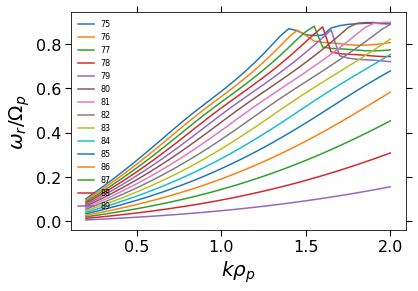

In [358]:
for i, wrel_arr in enumerate(wrel_2d):
    plt.plot(k_2d[i, :], wrel_arr.real, label = '{0:.3g}'.format(theta_arr[i]))
plt.xlabel(r'$k\rho_p$')
plt.ylabel(r'$\omega_r/\Omega_p$')
plt.legend(fontsize = 8, frameon=False)

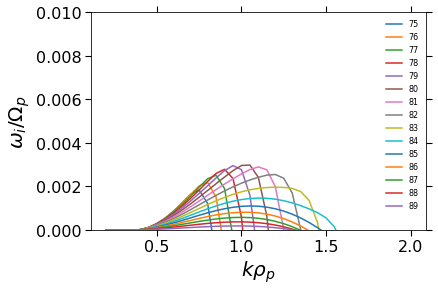

In [390]:
for i, wrel_arr in enumerate(wrel_2d):
    plt.plot(k_2d[i, :], wrel_arr.imag, label = '{0:.3g}'.format(theta_arr[i]))
plt.xlabel(r'$k\rho_p$')
plt.ylabel(r'$\omega_i/\Omega_p$')
plt.ylim([0, 1e-2])
plt.legend(fontsize = 8, frameon=False)

## interpolate to make 2d contour

In [360]:
import scipy.interpolate

In [361]:
def edges2grid(edges):
    """
    convert edges of histogram bins (from numpy.hist2d output) 
    to grid (center of the bins)
    """
    grid = (np.roll(edges, 1) + edges)/2
    return grid[1:]



## Interpolate in r-theta plane

In [362]:
# Set up a regular grid of interpolation points
xmin, xmax = 75, 89
ymin, ymax = 0.5, 1.5

x_edges, y_edges = np.linspace(xmin, xmax, 30), np.linspace(ymin, ymax, 50)
x_grid, y_grid = edges2grid(x_edges), edges2grid(y_edges)
x_i, y_i = np.meshgrid(x_grid, y_grid)
x_2d = np.array([[theta] * len(wrel_2d[0]) for theta in theta_arr])
y_2d = k_2d
z_2d = wrel_2d.real

wrel_real_i = scipy.interpolate.griddata((x_2d.flatten(), y_2d.flatten()), 
                                         wrel_2d.real.flatten(), (x_i, y_i), 
                                         method='linear')

wrel_imag_i = scipy.interpolate.griddata((x_2d.flatten(), y_2d.flatten()), 
                                         wrel_2d.imag.flatten(), (x_i, y_i), 
                                         method='linear')

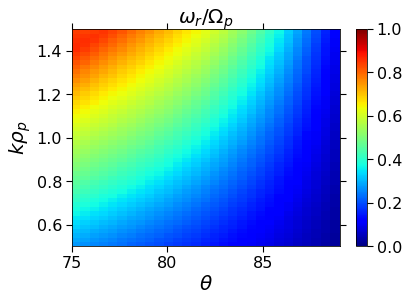

In [363]:
plt.pcolormesh(x_edges, y_edges, wrel_real_i, vmin=0, vmax=1, cmap = plt.cm.jet)
# plt.imshow(wrel_real_i.T, vmin=0, vmax=1, cmap = plt.cm.jet)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$k\rho_p$')
plt.title(r'$\omega_r/\Omega_p$')
plt.colorbar()
plt.show()

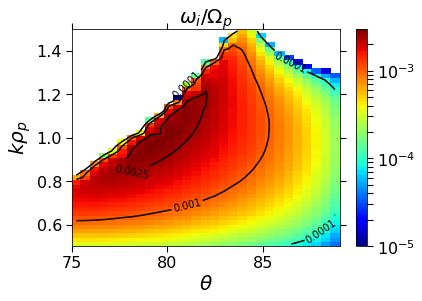

In [364]:
vmin, vmax = 1e-5, np.max(wrel_2d.imag)
z = np.ma.masked_where(np.isnan(wrel_imag_i), wrel_imag_i)
pcm = plt.pcolormesh(x_edges, y_edges, z, vmin=vmin, vmax=vmax, cmap = plt.cm.jet, 
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
CS = plt.contour(x_grid, y_grid, z, [1e-4, 1e-3, 2.5e-3], colors = 'k')
plt.clabel(CS, inline=1, fontsize=10, fmt='%.2g')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$k\rho_p$')
plt.title(r'$\omega_i/\Omega_p$')
plt.colorbar(pcm)
plt.show()

# interpolate in kz-kp plane

In [365]:
# Set up a regular grid of interpolation points
xmin, xmax = 1e-2, 0.25
ymin, ymax = 0.5, 1.5

x_edges, y_edges = np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200)
x_grid, y_grid = edges2grid(x_edges), edges2grid(y_edges)
x_i, y_i = np.meshgrid(x_grid, y_grid)
x_2d = kz_2d
y_2d = kp_2d
z_2d = wrel_2d.real

wrel_real_i = scipy.interpolate.griddata((x_2d.flatten(), y_2d.flatten()), 
                                         wrel_2d.real.flatten(), (x_i, y_i), 
                                         method='linear')

wrel_imag_i = scipy.interpolate.griddata((x_2d.flatten(), y_2d.flatten()), 
                                         wrel_2d.imag.flatten(), (x_i, y_i), 
                                         method='cubic')

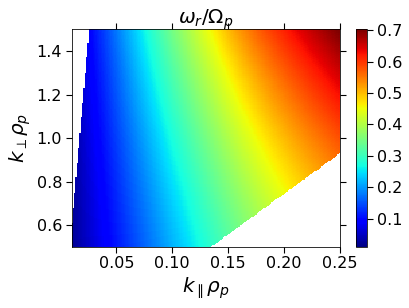

In [366]:
z = np.ma.masked_where(np.isnan(wrel_real_i), wrel_real_i)
plt.pcolormesh(x_edges, y_edges, 
               z, vmin=1e-2, vmax=np.max(z), cmap = plt.cm.jet)
# plt.imshow(wrel_real_i.T, vmin=0, vmax=1, cmap = plt.cm.jet)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$k_\parallel\rho_p$')
plt.ylabel(r'$k_\perp \rho_p$')
plt.title(r'$\omega_r/\Omega_p$')
plt.colorbar()
plt.show()

In [367]:
len(x_grid)

199

In [374]:
max_wi = np.max(wrel_imag_i[~np.isnan(wrel_imag_i)])
print(max_wi)
pos = np.where(wrel_imag_i == max_wi)
max_x = x_i[pos]/np.sqrt(2)
max_y = y_i[pos]/np.sqrt(2)

0.00303532478783


/Users/Tong/Envs/science/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


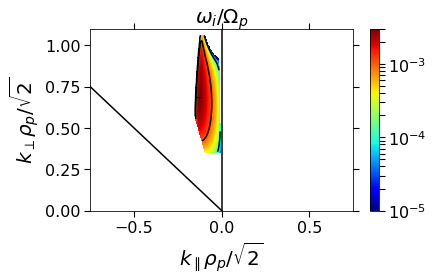

In [386]:
z = np.ma.masked_where(np.isnan(wrel_imag_i), wrel_imag_i)
vmin, vmax = 1e-5, np.max(z)
pcm = plt.pcolormesh(-x_edges/np.sqrt(2), y_edges/np.sqrt(2), z, 
                     vmin=vmin, vmax=vmax, cmap = plt.cm.jet, 
                     norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
CS = plt.contour(-x_grid/np.sqrt(2), y_grid/np.sqrt(2), z, [1e-4, 1e-3], colors = 'k')
# plt.clabel(CS, inline=1, fontsize=8, fmt='%.2g')
plt.xlim([-.75, .75])
plt.ylim([0, 1.1])
plt.plot(-max_x, max_y, 'k+')
plt.plot([0,-1], [0, 1], 'k')
plt.xlabel(r'$k_\parallel\rho_p/\sqrt{2}$')
plt.ylabel(r'$k_\perp \rho_p/\sqrt{2}$')
plt.title(r'$\omega_i/\Omega_p$')
plt.axvline(0, color = 'k')
plt.colorbar(pcm)
plt.tight_layout()
# plt.savefig('figure/gary_1975_fig4_reproduced.png', dpi = 200)

0.00303532478783


array([ 0.12944673])

array([ 0.68578698])

## Find maximum growth rate by 2D interpolation in $k-\theta$ plane

In [281]:
from scipy.interpolate import interp2d

In [287]:
x_2d = np.array([[theta] * len(wrel_2d[0]) for theta in theta_arr])
y_2d = k_2d
z_2d = wrel_2d

real_f = interp2d(x_2d.flatten(), y_2d.flatten(), z_2d.real.flatten())
imag_f = interp2d(x_2d.flatten(), y_2d.flatten(), z_2d.imag.flatten())

/Users/Tong/Envs/science/lib/python3.6/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=20,33 m=555 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/Tong/Envs/science/lib/python3.6/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=19,35 m=555 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [291]:
# Set up a regular grid of interpolation points
xmin, xmax = 75, 89
ymin, ymax = 0.5, 1.5

x_edges, y_edges = np.linspace(xmin, xmax, 30), np.linspace(ymin, ymax, 50)
x_grid, y_grid = edges2grid(x_edges), edges2grid(y_edges)
x_i, y_i = np.meshgrid(x_grid, y_grid)
z_i = np.array([imag_f(x, y) for x, y in zip(x_i.flatten(), y_i.flatten())]).reshape(x_i.shape)

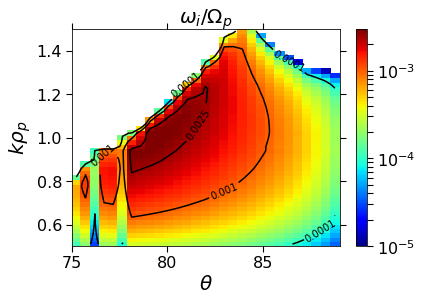

In [292]:
vmin, vmax = 1e-5, np.max(wrel_2d.imag)
z = np.ma.masked_where(np.isnan(z_i), z_i)
pcm = plt.pcolormesh(x_edges, y_edges, z, vmin=vmin, vmax=vmax, cmap = plt.cm.jet, 
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
CS = plt.contour(x_grid, y_grid, z, [1e-4, 1e-3, 2.5e-3], colors = 'k')
plt.clabel(CS, inline=1, fontsize=10, fmt='%.2g')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$k\rho_p$')
plt.title(r'$\omega_i/\Omega_p$')
plt.colorbar(pcm)
plt.show()

## 2d interpolate in kp-kz plane

In [296]:
x_2d = kz_2d
y_2d = kp_2d
z_2d = wrel_2d

real_f = interp2d(x_2d.flatten(), y_2d.flatten(), z_2d.real.flatten())
imag_f = interp2d(x_2d.flatten(), y_2d.flatten(), z_2d.imag.flatten())

/Users/Tong/Envs/science/lib/python3.6/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=29,23 m=555 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/Tong/Envs/science/lib/python3.6/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=24,19 m=555 fp=0.000067 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [297]:
# Set up a regular grid of interpolation points
xmin, xmax = 1e-2, 0.25
ymin, ymax = 0.5, 1.5

x_edges, y_edges = np.linspace(xmin, xmax, 30), np.linspace(ymin, ymax, 50)
x_grid, y_grid = edges2grid(x_edges), edges2grid(y_edges)
x_i, y_i = np.meshgrid(x_grid, y_grid)
z_i = np.array([imag_f(x, y) for x, y in zip(x_i.flatten(), y_i.flatten())]).reshape(x_i.shape)

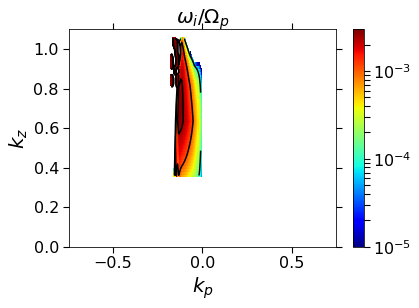

In [302]:
vmin, vmax = 1e-5, np.max(wrel_2d.imag)
z = np.ma.masked_where(np.isnan(z_i), z_i)
pcm = plt.pcolormesh(-x_edges/np.sqrt(2), y_edges/np.sqrt(2), z, vmin=vmin, vmax=vmax, cmap = plt.cm.jet, 
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
CS = plt.contour(-x_grid/np.sqrt(2), y_grid/np.sqrt(2), z, [1e-4, 1e-3, 2.5e-3], colors = 'k')

plt.xlim([-.75, .75])
plt.ylim([0, 1.1])
plt.xlabel(r'$k_p$')
plt.ylabel(r'$k_z$')
plt.title(r'$\omega_i/\Omega_p$')
plt.colorbar(pcm)
plt.show()